In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
from sympy.physics.quantum.constants import hbar

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import animation

In [2]:
#actual integrator, with adaptive stepsizes
def rkint(f0, t0, h):
    k1 = h*rhs(f0, t0)
    k2 = h*rhs(f0 + k1/5, t0 + h/5)
    k3 = h*rhs(f0 + k1*3/40 + k2*9/40, t0 + h*3/10)
    k4 = h*rhs(f0 + k1*3/10 - k2*9/10 + k3*6/5, t0 + h*3/5)
    k5 = h*rhs(f0 - k1*11/54 + k2*5/2 - k3*70/27 + k4*35/27, t0 + h)
    k6 = h*rhs(f0 + k1*1631/55296 + k2*175/512 + k3*575/13824 + k4*44275/110592 + k5*253/4096, t0 + h*7/8)
    
    f = f0 + k1*37/378 + k3*250/621 + k4*125/594 + k6*512/1771
    fstar = f0 + k1*2825.0/27648.0 + k3*18575.0/48384.0 + k4*13525.0/55296.0 + k5*277.0/14336.0 + k6/4.0
    
    maxtol = 10**-6
    
    goodenough = np.absolute(maxtol/(np.max(fstar-f)))
    h0 = h*goodenough**0.2
    if goodenough < 1:
        
        f = tryagain(f0, t0, h, h0)
    
    return f
    
def tryagain(f0, t0, h, h0):
    step2 = round(h/h0 + 0.5)
    t = np.linspace(t0, h, step2)
    new = [f0]
    for tval in t:
        new.append(rkint(new[-1], tval, h/step2))
    return new[-1]
        

In [15]:
#define the right hand side of your function
def rhs(f, t):
    return -(0.0+1.0j)*ksq*(psihat) + (0.0+1.0j)*potential(psihat)

#do potential term in real space, return fourier space
def potential(psihat):
    psi = np.fft.irfft2(psihat)
    return np.fft.rfft2((xx**2+yy**2)*psi)

In [16]:
#give it some initial conditions
step = 500
tmax = 200
tt = np.linspace(0.0, tmax, step)

#real space set up
x = np.linspace(-np.pi, np.pi, 256)
y = np.linspace(-np.pi, np.pi, 256)
xx, yy = np.meshgrid(x, y)
psi = np.exp(xx**2/(np.pi**2)) * np.exp(yy**2/(np.pi**2))

#fourier space set up
kx = np.fft.rfftfreq(256)
ky = np.fft.fftfreq(256)
kkx, kky = np.meshgrid(kx, ky)
ksq = kkx**2 + kky**2
psihat = np.fft.rfft(psi)

init = psihat

In [17]:
#this will do all the work
tt = np.linspace(0, tmax, step)
h = tmax/(step)
resulthat = [init]

for tval in tt:
    resulthat.append(rkint(resulthat[-1], tval, h))
result = np.fft.irfft(np.array(resulthat))

In [18]:
result[0]

array([[ 7.3890561 ,  7.27450115,  7.16260334, ...,  7.16260334,
         7.27450115,  7.3890561 ],
       [ 7.27450115,  7.16172218,  7.05155916, ...,  7.05155916,
         7.16172218,  7.27450115],
       [ 7.16260334,  7.05155916,  6.94309069, ...,  6.94309069,
         7.05155916,  7.16260334],
       ..., 
       [ 7.16260334,  7.05155916,  6.94309069, ...,  6.94309069,
         7.05155916,  7.16260334],
       [ 7.27450115,  7.16172218,  7.05155916, ...,  7.05155916,
         7.16172218,  7.27450115],
       [ 7.3890561 ,  7.27450115,  7.16260334, ...,  7.16260334,
         7.27450115,  7.3890561 ]])

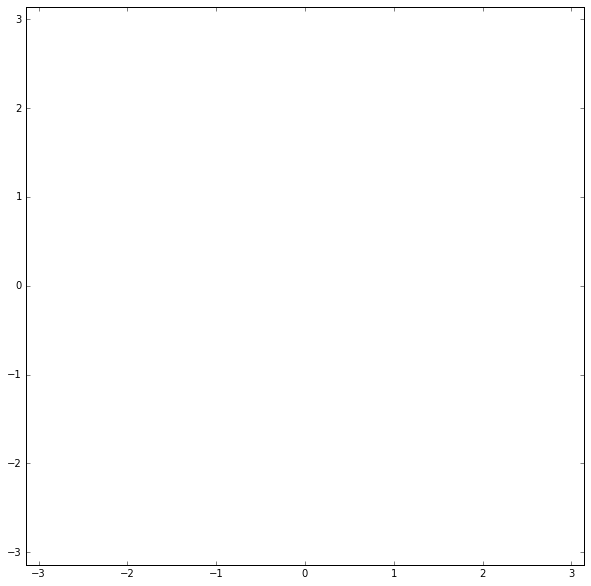

In [19]:
#create our plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes()  
plt.xlabel('x')
plt.ylabel('y')

totalmax = np.max([np.max(np.abs(result)) for frame in result])
levels = np.linspace(-totalmax, totalmax, 10)



#animation function
def animatepsi(i):
    ax.clear()
    return plt.contour(xx, yy, result[i], levels)


anim = animation.FuncAnimation(fig, animatepsi, frames=len(tt), blit=False)
mywriter = animation.FFMpegWriter()

anim.save("gaussianshocluster.mp4", writer=mywriter)